Το πρόγραμμα τρέχει στο τερματικό με την εντολή <br>
'python part2.py <image_path> <local_model_path>' ή <br>
'python part2.py <image_path>'<br>
το local_model_path είναι προαιρετικό και χρησιμοποιείται για να μην καθηστερούν οι δοκιμές κατεβάζοντας συνέχεια το model.

In [22]:
import os
import tarfile
import tempfile
from six.moves import urllib
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randint
from sklearn.decomposition import PCA
#from sys import argv #in the original

In [3]:
class DeepLabModel(object):
	INPUT_TENSOR_NAME = 'ImageTensor:0'
	OUTPUT_TENSOR_NAME = 'concat_projection/Conv2D:0'
	INPUT_SIZE = 513
	FROZEN_GRAPH_NAME = 'frozen_inference_graph'

	def __init__(self, tarball_path):
		self.graph = tf.Graph()

		graph_def = None
		#Extract frozen graph from tar archive.
		#by opening the tar and looking for the 'FROZEN_GRAPH_NAME' file
		tar_file = tarfile.open(tarball_path)
		for tar_info in tar_file.getmembers():
			if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
				file_handle = tar_file.extractfile(tar_info)
				graph_def = tf.GraphDef.FromString(file_handle.read())
				break

		tar_file.close()

		if graph_def is None:
			raise RuntimeError('Cannot find inference graph in tar archive.')
		
		#add the operations of the FROZEN_GRAPH_NAME to the graph
		with self.graph.as_default():
			tf.import_graph_def(graph_def, name='')
		#start the session to execute the graph operations
		self.sess = tf.Session(graph=self.graph)

	def run(self, image):
		#resize image
		width, height = image.size #get original size
		resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height) 
		target_size = (int(resize_ratio * width), int(resize_ratio * height)) #get size
		resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS) #resize image
		#run session with the resized image
		batch_seg_map = self.sess.run(
				self.OUTPUT_TENSOR_NAME,
				feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
		seg_map = np.array(batch_seg_map[0])#turn Tensor into np array
		#new sizes for seg map
		Χ = seg_map.shape[0]*seg_map.shape[1]
		Υ = seg_map.shape[-1]
		#reshape seg map
		seg_map_reshaped = np.reshape(seg_map, [Χ, Υ])
		#apply pca to the reshaped seg map
		seg_map_reduced = PCA(n_components=3).fit_transform(seg_map_reshaped)
		#turn the result back into an image
		result = np.reshape(seg_map_reduced, [seg_map.shape[0], seg_map.shape[1], 3])
		return resized_image, result

In [14]:
def vis_segmentation(image, seg_map):
	"""Visualizes input image, segmentation map and overlay view."""
	plt.figure(figsize=(15, 5))
	grid_spec = gridspec.GridSpec(1, 2)
	#show original image
	plt.subplot(grid_spec[0])
	plt.imshow(image)
	plt.axis('off')
	plt.title('input image')
	#show "colorized" image
	plt.subplot(grid_spec[1])
	plt.imshow(seg_map)
	plt.axis('off')
	plt.title('PCA Result')
	plt.grid('off')
	plt.show()

In [21]:
def main(image):
	img = Image.open(image)
	#run the model from the example
	print('running deeplab on image %s...' % image)
	resized_im, df_image = MODEL.run(img)
	vis_segmentation(resized_im, df_image)

In [8]:
#just for testing so that you don't have to download the model every time
argv = ['', 'image_name', 'deeplab_model4.tar.gz']#using a local model ('mobilenetv2_coco_voctrainaug') only for the test
if len(argv) < 2:
	_DOWNLOAD_URL = 'http://download.tensorflow.org/models/deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz'#model url
	_TARBALL_NAME = 'deeplab_model.tar.gz'#name of the downloaded temp file
	model_dir = tempfile.mkdtemp()
	tf.gfile.MakeDirs(model_dir)
    
	download_path = os.path.join(model_dir, _TARBALL_NAME)
	print('downloading model, this might take a while...')
	urllib.request.urlretrieve(_DOWNLOAD_URL, download_path)
	print('download completed! loading DeepLab model...')
else:
	download_path = argv[2]
MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

model loaded successfully!


running deeplab on image image2.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


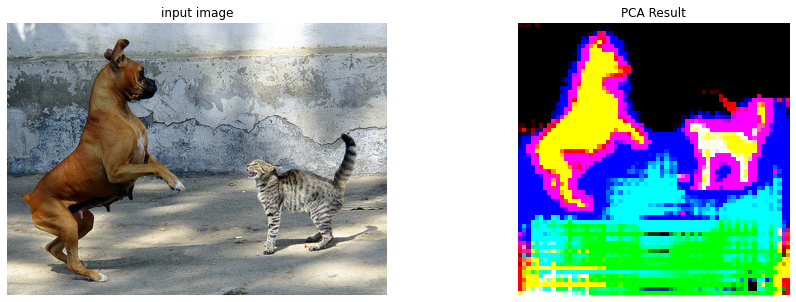

In [15]:
main('image2.jpg')

running deeplab on image image1.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


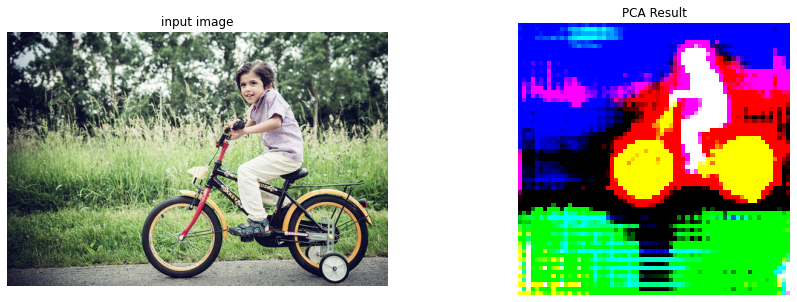

In [16]:
main('image1.jpg')

running deeplab on image office.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


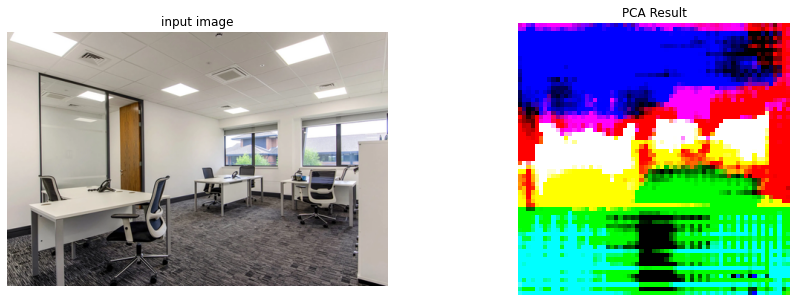

In [17]:
main('office.jpg')

running deeplab on image image4.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


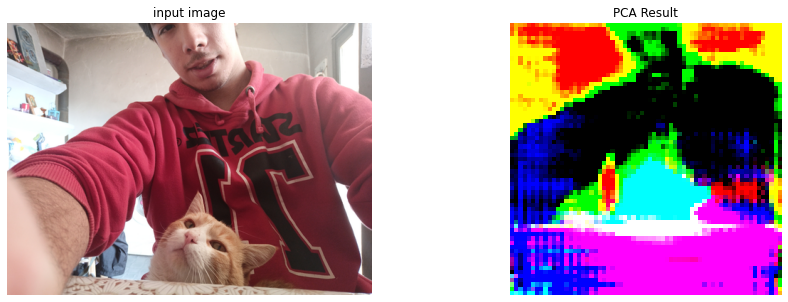

In [18]:
main('image4.jpg')

running deeplab on image image3.jpg...


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


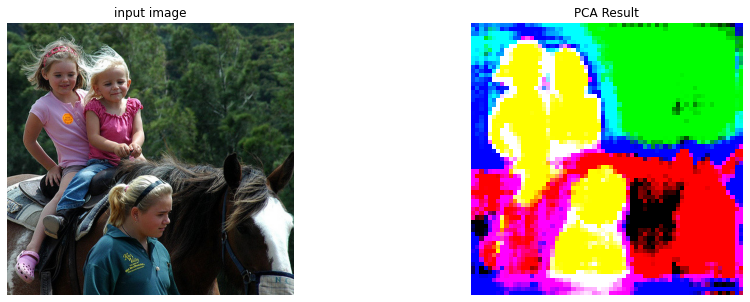

In [19]:
main('image3.jpg')